In [1]:
%matplotlib inline

In [2]:
import gzip

import numpy as np
import scipy as scp
import matplotlib.pyplot as plt
import seaborn as sns
import sklearn
from sklearn.cross_validation import train_test_split

from utils import effectiveDimension, factorize, gram, hiddenTargets

import sklearn
from sklearn.linear_model import LogisticRegression

## MNIST dataset

In [3]:
def parse_img(filename):
    '''Parses mnist images in filename.'''
    f = gzip.open(filename)
    arr = np.frombuffer(f.read(), dtype=np.dtype('>u1'), offset=16)
    arr = arr.astype(np.int64)
    f.close()
    return arr.reshape((-1, 28*28))

def parse_label(filename):
    '''Parses mnist labels in filename.'''
    f = gzip.open(filename)
    arr = np.frombuffer(f.read(), dtype=np.dtype('>u1'), offset=8)
    f.close()
    return arr

In [4]:
X_data = parse_img('mnist data/train-images-idx3-ubyte.gz')
y_data = parse_label('mnist data/train-labels-idx1-ubyte.gz')
print(X_data.shape, X_data.dtype)
print(y_data.shape, y_data.dtype)

(60000, 784) int64
(60000,) uint8


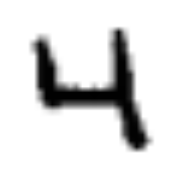

In [106]:
def plot_img(x):
    plt.figure(figsize=(3, 3))
    plt.imshow(x.reshape((28, 28)), cmap=plt.cm.gray_r)
    plt.grid(False)
    plt.tick_params(labelbottom=False, labelleft=False)

plot_img(X_data[np.random.randint(0, len(X_data))])

In [128]:
# We'll use the 3s and 8s.
X3 = X_data[y_data == 3]
X8 = X_data[y_data == 8]
print(X3.shape)
print(X8.shape)
print()

X = np.vstack([X3, X8])
y = np.concatenate([[-1] * len(X3), [1] * len(X8)])
print(X.shape)
print(y.shape)
print()


(6131, 784)
(5851, 784)

(11982, 784)
(11982,)



In [129]:
# Pick a mix of easy and hard samples
model = LogisticRegression(C=.0001)
model.fit(X, y)
print("accuracy:", sum(model.predict(X) == y) / len(y))

accuracy: 0.980136871975


In [130]:
hard = X[model.predict(X) != y]
hardLabels = y[model.predict(X) != y]

easy = X[model.predict(X) == y]
easyLabels = y[model.predict(X) == y]

numHard = len(hard)
hardX_train, hardX_test, hardY_train, hardY_test = train_test_split(hard, hardLabels, train_size=int(numHard/2))

easyX_train, easyX_test, easyY_train, easyY_test = train_test_split(easy, easyLabels, train_size=2000)

X_train = np.vstack([hardX_train, easyX_train])
X_test = np.vstack([hardX_test, easyX_test])

y_train = np.concatenate([hardY_train, easyY_train])
y_test = np.concatenate([hardY_test, easyY_test])

print(X_train.shape)
print(y_train.shape)
print(X_test.shape)
print(y_test.shape)

(2119, 784)
(2119,)
(9863, 784)
(9863,)


In [131]:
def preprocessX(X):
    m = np.mean(X, axis=0)
    X = X - m
    norms = np.linalg.norm(X, axis=1)
    mNorm = np.mean(norms)
    X = X / mNorm
    return X
    
X_train = preprocessX(X_train)

In [8]:
%%time
test = gram(X_train)

CPU times: user 136 ms, sys: 6.57 ms, total: 143 ms
Wall time: 84 ms


In [9]:
%%time
r = scp.linalg.eigh(test)

CPU times: user 584 ms, sys: 21.4 ms, total: 605 ms
Wall time: 455 ms


Label of sample image is 1


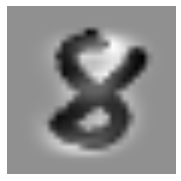

In [134]:
# Sanity check.
sampleImgIdx = np.random.randint(0, len(X_train))
sampleImg = X_train[sampleImgIdx]
sampleLabel = y_train[sampleImgIdx]
print('Label of sample image is ' + str(sampleLabel))
plot_img(sampleImg)

## Next steps
1. Plot eigenvalues as a function of i where i is the ith largest eigenvalue. Do for different $\alpha \in [0, 1]$
1. Plot $d_{95}$ (effective dimension) as a function of $\alpha$.
1. Logistic (or SVM) error as a function of $\alpha$. (note hidden targest are input an label targets). 

Question:
Throw away eigenvalues below some threshold. Not the same as $d_{95}$

In [120]:
XG = gram(X_train)
YG = gram(y_train[:, np.newaxis])

In [124]:
alpha = .9
H, eigvals = hiddenTargets(XG, YG, alpha)
np.allclose(H.dot(H.T), alpha * XG + (1 - alpha) * YG)
print(eigvals.shape)

(572,)


In [126]:
effectiveDimension(eigvals)

10

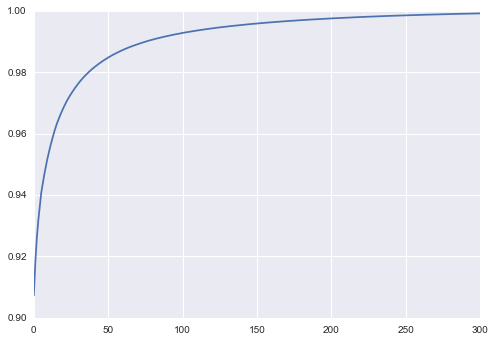

In [127]:
plt.plot(eigvals.cumsum() / eigvals.sum())
plt.xlim((0, 300));

In [15]:
ls data/

1455174040/


## IO function
To help with saving and loading experiments.

In [135]:
from time import time
import os
from os.path import isdir, join
from glob import fnmatch

def filePrefix(alpha):
    '''x is a float.'''
    s = str(alpha)
    prefix = s[0] + s[2:4]
    return 'alpha_' + (prefix if len(prefix) == 3 else prefix + '0') + '_'


def createSaveDirectory():
    '''Creates a unique directory in data/ based on timestamp.'''
    directoryName = str(int(time()))
    path = join('data', directoryName)
    !mkdir $path
    assert isdir(path), 'Directory does not exist\n{0}'.format(path)
    return path

    
def save(arr, alpha, path, which): 
    '''
    arr: The numpy array to save.
    alpha: The alpha associated with this calculation. See above definition.
    path: the directory to store the data.
    which: either "eigvals" or "H".
    
    returns an iterator of stored eigvals or H.
    '''
    fname = join(path, filePrefix(alpha) + which)
    np.save(fname, arr)
    print('Saved: ' + fname)
  

def load(path, which):
    '''
    path: the directory of the data.
    which: either "eigvals" or "H".
    
    returns an iterator of stored eigvals or H.
    '''
    fnames = fnmatch.filter(os.listdir(path), '*{0}*'.format(which))
    for fname in sorted(fnames):
        fullPath = join(path, fname)
        print('Loading: {0}'.format(fullPath))
        yield np.load(fullPath)
        


In [136]:
def computeHiddenTargets(alphas, X, y):
    XG = gram(X)
    YG = gram(y[:, np.newaxis])

    path = createSaveDirectory()
    print('Saving results in dir: ' + path)
    for alpha in alphas:
        H, eigvals = hiddenTargets(XG, YG, alpha)
        save(H, alpha, path, 'H')
        save(eigvals, alpha, path, 'eigvals')
        
alphas = np.arange(0, .12, 0.01)
computeHiddenTargets(alphas, X_train, y_train)

Saving results in dir: data/1456383745
Saved: data/1456383745/alpha_000_H
Saved: data/1456383745/alpha_000_eigvals
Saved: data/1456383745/alpha_001_H
Saved: data/1456383745/alpha_001_eigvals
Saved: data/1456383745/alpha_002_H
Saved: data/1456383745/alpha_002_eigvals
Saved: data/1456383745/alpha_003_H
Saved: data/1456383745/alpha_003_eigvals
Saved: data/1456383745/alpha_004_H
Saved: data/1456383745/alpha_004_eigvals
Saved: data/1456383745/alpha_005_H
Saved: data/1456383745/alpha_005_eigvals
Saved: data/1456383745/alpha_006_H
Saved: data/1456383745/alpha_006_eigvals
Saved: data/1456383745/alpha_007_H
Saved: data/1456383745/alpha_007_eigvals
Saved: data/1456383745/alpha_008_H
Saved: data/1456383745/alpha_008_eigvals
Saved: data/1456383745/alpha_009_H
Saved: data/1456383745/alpha_009_eigvals
Saved: data/1456383745/alpha_010_H
Saved: data/1456383745/alpha_010_eigvals
Saved: data/1456383745/alpha_011_H
Saved: data/1456383745/alpha_011_eigvals


In [137]:
ls data

1456380479/ 1456383745/


In [ ]:
# Careful!!
# !rm -r data/*

In [85]:
eigvals = load('data/1456383745/', which='eigvals')

In [138]:
alphas.shape

(12,)

Loading: data/1456383745/alpha_000_eigvals.npy
Loading: data/1456383745/alpha_001_eigvals.npy
Loading: data/1456383745/alpha_002_eigvals.npy
Loading: data/1456383745/alpha_003_eigvals.npy
Loading: data/1456383745/alpha_004_eigvals.npy
Loading: data/1456383745/alpha_005_eigvals.npy
Loading: data/1456383745/alpha_006_eigvals.npy
Loading: data/1456383745/alpha_007_eigvals.npy
Loading: data/1456383745/alpha_008_eigvals.npy
Loading: data/1456383745/alpha_009_eigvals.npy
Loading: data/1456383745/alpha_010_eigvals.npy
Loading: data/1456383745/alpha_011_eigvals.npy


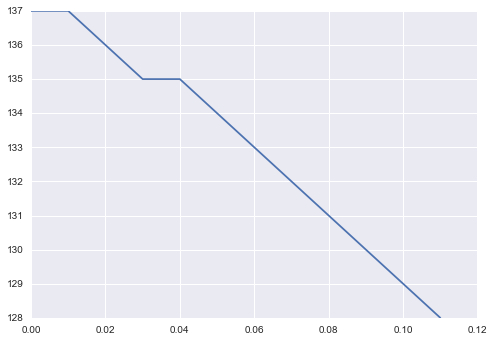

In [139]:
eigvals = load('data/1456383745/', which='eigvals')
p95 = np.array([effectiveDimension(eigval, p=0.95) for eigval in eigvals])
plt.plot(alphas, p95)

Loading: data/1456383745/alpha_000_eigvals.npy
Loading: data/1456383745/alpha_001_eigvals.npy
Loading: data/1456383745/alpha_002_eigvals.npy
Loading: data/1456383745/alpha_003_eigvals.npy
Loading: data/1456383745/alpha_004_eigvals.npy
Loading: data/1456383745/alpha_005_eigvals.npy
Loading: data/1456383745/alpha_006_eigvals.npy
Loading: data/1456383745/alpha_007_eigvals.npy
Loading: data/1456383745/alpha_008_eigvals.npy
Loading: data/1456383745/alpha_009_eigvals.npy
Loading: data/1456383745/alpha_010_eigvals.npy
Loading: data/1456383745/alpha_011_eigvals.npy


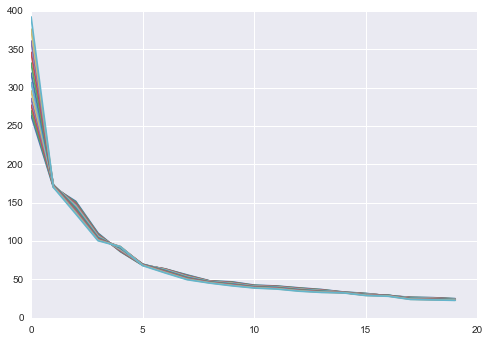

In [140]:
plt.hold(True)
for eigvals in load('data/1456383745/', which='eigvals'):
    plt.plot(eigvals[:20])
    
plt.hold(False)

Loading: data/1456383745/alpha_000_eigvals.npy
Loading: data/1456383745/alpha_001_eigvals.npy
Loading: data/1456383745/alpha_002_eigvals.npy
Loading: data/1456383745/alpha_003_eigvals.npy
Loading: data/1456383745/alpha_004_eigvals.npy
Loading: data/1456383745/alpha_005_eigvals.npy
Loading: data/1456383745/alpha_006_eigvals.npy
Loading: data/1456383745/alpha_007_eigvals.npy
Loading: data/1456383745/alpha_008_eigvals.npy
Loading: data/1456383745/alpha_009_eigvals.npy
Loading: data/1456383745/alpha_010_eigvals.npy
Loading: data/1456383745/alpha_011_eigvals.npy


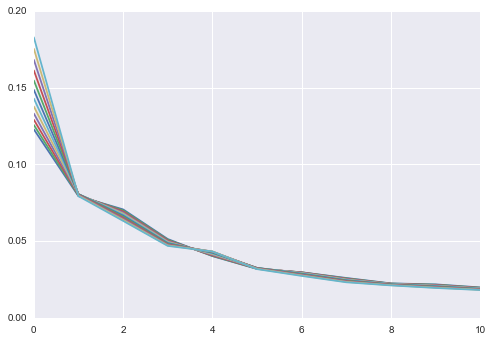

In [145]:
plt.xlim(0, 10)
plt.hold(True)
for eigvals in load('data/1456383745/', which='eigvals'):
    plt.plot(eigvals / eigvals.sum())
plt.hold(False);

In [146]:
acc_train = []
for H in load('data/1456383745/', which='H'):
    print(H.shape)
    model = LogisticRegression(C=.001)
    model.fit(H, y_train)
#     acc_train.append((model.predict(H) == y_test).mean())
    acc_train.append(model.score(H, y_train))
    

Loading: data/1456383745/alpha_000_H.npy
(2119, 556)
Loading: data/1456383745/alpha_001_H.npy
(2119, 557)
Loading: data/1456383745/alpha_002_H.npy
(2119, 557)
Loading: data/1456383745/alpha_003_H.npy
(2119, 557)
Loading: data/1456383745/alpha_004_H.npy
(2119, 557)
Loading: data/1456383745/alpha_005_H.npy
(2119, 557)
Loading: data/1456383745/alpha_006_H.npy
(2119, 557)
Loading: data/1456383745/alpha_007_H.npy
(2119, 557)
Loading: data/1456383745/alpha_008_H.npy
(2119, 557)
Loading: data/1456383745/alpha_009_H.npy
(2119, 557)
Loading: data/1456383745/alpha_010_H.npy
(2119, 557)
Loading: data/1456383745/alpha_011_H.npy
(2119, 557)


In [147]:
print(acc_train)

[0.84285040113260967, 0.87730061349693256, 0.90703161868806037, 0.93109957527135445, 0.94808872109485609, 0.96507786691835773, 0.97734780556866452, 0.98584237848041534, 0.99103350637092968, 0.99575271354412453, 0.99811231713072202, 1.0]


Schedule Rob
Mondays: Anytime
Wednesdays: anytime. 
Thursdays: 12:30 - 1:45, 3:30 - 4:45
Fridays: After surfing.